# Классификация Decision Tree

## Импорт модулей

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
)
from sklearn.tree import plot_tree

## Константы

In [2]:
TRAIN_PATH = "../Lesson38/smoking_data/train_dataset.csv"
TARGET = "smoking"
RANDOM_STATE = 777
TEST_SIZE = 0.2

## Загрузка данных

In [3]:
df = pd.read_csv(TRAIN_PATH)

print("Train DataFrame")
df.head()

Train DataFrame


,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,relaxation,...,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries,smoking
0,35,170,85,97.0,0.9,0.9,1,1,118,78,...,70,142,19.8,1,1.0,61,115,125,1,1
1,20,175,110,110.0,0.7,0.9,1,1,119,79,...,71,114,15.9,1,1.1,19,25,30,1,0
2,45,155,65,86.0,0.9,0.9,1,1,110,80,...,57,112,13.7,3,0.6,1090,1400,276,0,0
3,45,165,80,94.0,0.8,0.7,1,1,158,88,...,46,91,16.9,1,0.9,32,36,36,0,0
4,20,165,60,81.0,1.5,0.1,1,1,109,64,...,47,92,14.9,1,1.2,26,28,15,0,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38984 entries, 0 to 38983
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   age                  38984 non-null  int64  
 1   height(cm)           38984 non-null  int64  
 2   weight(kg)           38984 non-null  int64  
 3   waist(cm)            38984 non-null  float64
 4   eyesight(left)       38984 non-null  float64
 5   eyesight(right)      38984 non-null  float64
 6   hearing(left)        38984 non-null  int64  
 7   hearing(right)       38984 non-null  int64  
 8   systolic             38984 non-null  int64  
 9   relaxation           38984 non-null  int64  
 10  fasting blood sugar  38984 non-null  int64  
 11  Cholesterol          38984 non-null  int64  
 12  triglyceride         38984 non-null  int64  
 13  HDL                  38984 non-null  int64  
 14  LDL                  38984 non-null  int64  
 15  hemoglobin           38984 non-null 

## Исследовательский анализ данных

Проверка дубликатов.

In [5]:
print(f"Количество дубликатов: {df.duplicated().sum()}")

Количество дубликатов: 5517


Удаление дубликатов.

In [6]:
df = df.drop_duplicates()
df.reset_index(drop=True, inplace=True)

print(f"Количество дубликатов: {df.duplicated().sum()}")

Количество дубликатов: 0


In [7]:
def numeric_columns_stats(df):
    stats = pd.DataFrame(index=df.columns)
    stats["Доля пропусков"] = df.isnull().mean()
    stats["Минимум"] = df.min().round(2)
    stats["Максимум"] = df.max().round(2)
    stats["Среднее"] = df.mean().round(2)
    stats["Медиана"] = df.median().round(2)
    stats["Дисперсия"] = df.var().round(2)
    stats["Квантиль 0.1"] = df.quantile(0.1).round(2)
    stats["Квантиль 0.9"] = df.quantile(0.9).round(2)
    stats["Квартиль 1"] = df.quantile(0.25).round(2)
    stats["Квартиль 3"] = df.quantile(0.75).round(2)

    return stats

In [8]:
# Результаты EDA для числовых признаков
numeric_columns_stats(df)

,Доля пропусков,Минимум,Максимум,Среднее,Медиана,Дисперсия,Квантиль 0.1,Квантиль 0.9,Квартиль 1,Квартиль 3
age,0.0,20.0,85.0,44.15,40.0,145.73,30.0,60.0,40.0,55.0
height(cm),0.0,130.0,190.0,164.68,165.0,84.56,150.0,175.0,160.0,170.0
weight(kg),0.0,30.0,135.0,65.93,65.0,165.84,50.0,85.0,55.0,75.0
waist(cm),0.0,51.0,129.0,82.08,82.0,86.69,70.0,94.0,76.0,88.0
eyesight(left),0.0,0.1,9.9,1.01,1.0,0.25,0.6,1.5,0.8,1.2
eyesight(right),0.0,0.1,9.9,1.01,1.0,0.25,0.6,1.5,0.8,1.2
hearing(left),0.0,1.0,2.0,1.03,1.0,0.02,1.0,1.0,1.0,1.0
hearing(right),0.0,1.0,2.0,1.03,1.0,0.03,1.0,1.0,1.0,1.0
systolic,0.0,71.0,233.0,121.50,120.0,186.90,104.0,138.0,112.0,130.0
relaxation,0.0,40.0,146.0,76.02,76.0,93.55,64.0,88.0,70.0,82.0


Данные не содержат пропущенные значения и имеют различный масштаб.

## Подготовка датасета к построению моделей ML

### Распределение целевой переменной

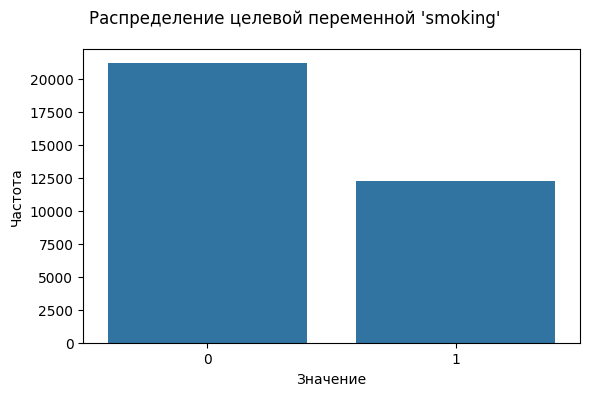

In [9]:
# Визуализация распределения целевой переменной
fig, ax = plt.subplots(figsize=(6, 4))

sns.barplot(df[TARGET].value_counts(), ax=ax)
ax.set_xlabel("Значение")
ax.set_ylabel("Частота")

plt.suptitle(f"Распределение целевой переменной '{TARGET}'")
plt.tight_layout()
plt.show()

В распределении целевого признака преобладает доля некурящих людей.

### Распределение числовых переменных

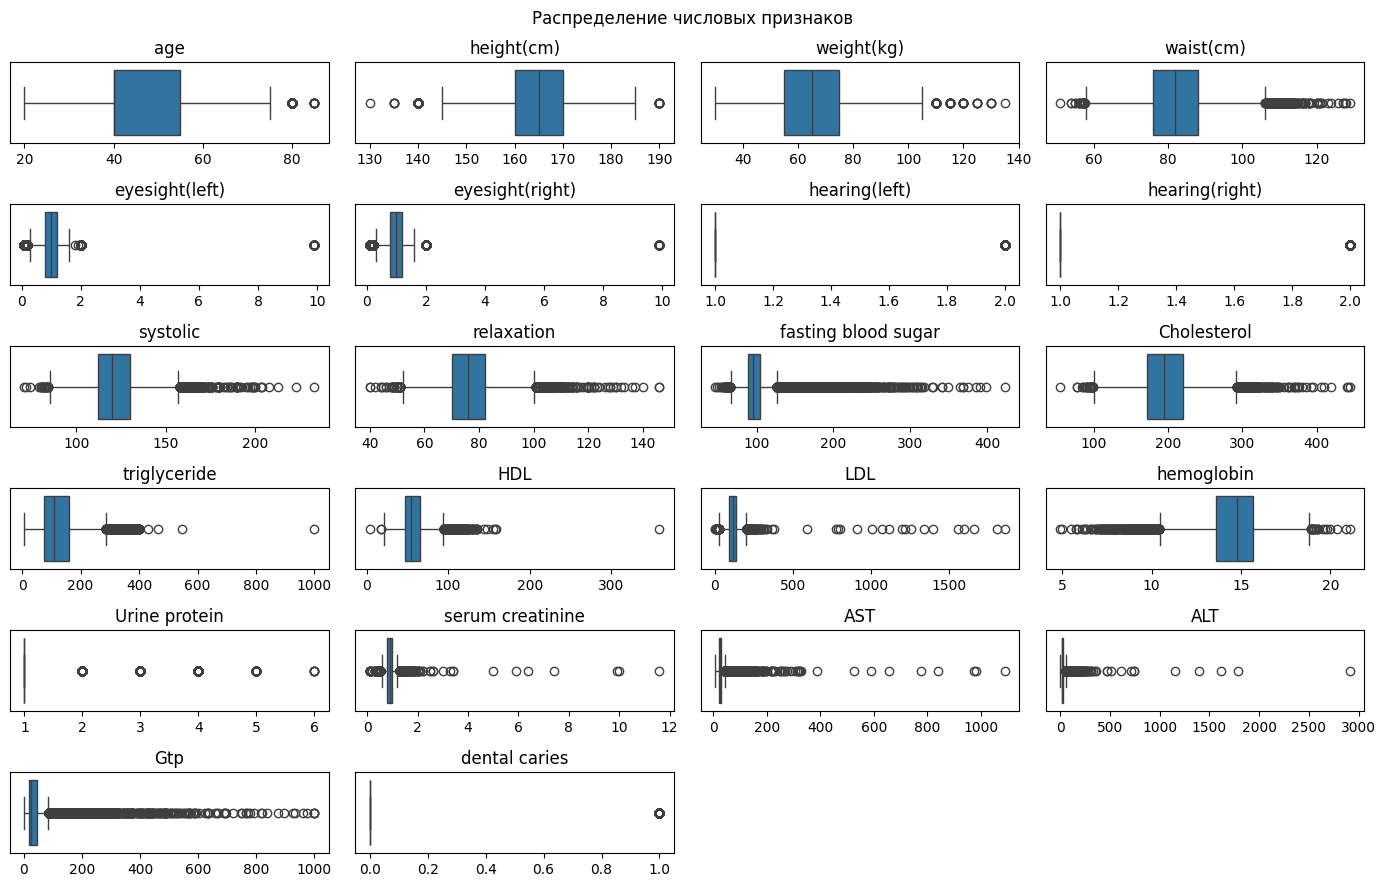

In [10]:
fig, ax = plt.subplots(6, 4, figsize=(14, 9))

for i, col in enumerate([col for col in df.columns if col != TARGET]):
    row_idx, col_idx = divmod(i, 4)
    sns.boxplot(df[col], ax=ax[row_idx, col_idx], orient="h")
    ax[row_idx, col_idx].set_title(col)
    ax[row_idx, col_idx].set_xlabel(None)
    ax[row_idx, col_idx].set_yticks([])

for i in range(len(df.columns) - 1, len(ax.flatten())):
    fig.delaxes(ax.flatten()[i])

plt.suptitle("Распределение числовых признаков")
plt.tight_layout()
plt.show()

Можно видеть, что числовые переменные имеют широкие диапазоны изменений, которые нельзя однозначно отнести к выбросам, оставим признаки без изменений.

### Построение информативных графиков

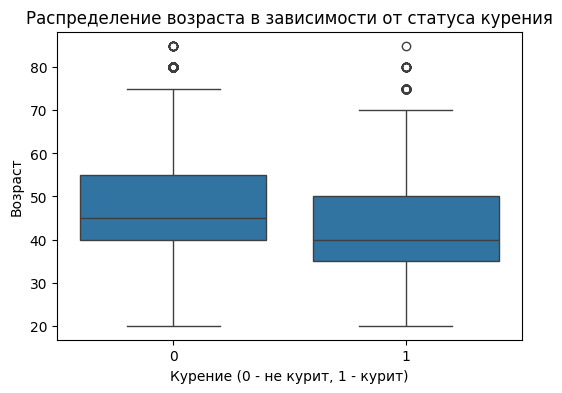

In [11]:
# Зависимости возраста от статуса курения
plt.figure(figsize=(6, 4))
sns.boxplot(x=df["smoking"], y=df["age"])
plt.title("Распределение возраста в зависимости от статуса курения")
plt.xlabel("Курение (0 - не курит, 1 - курит)")
plt.ylabel("Возраст")
plt.show()

Можно видеть, что отказ от курения немного увеличивает продолжительность жизни.

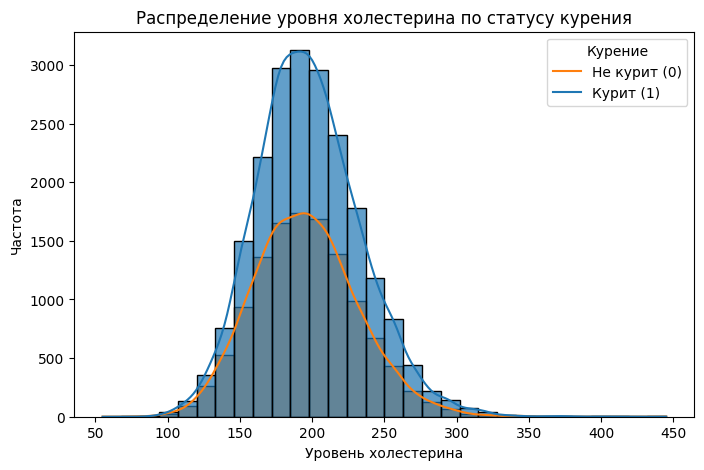

In [12]:
# Распределение уровня холестерина в зависимости от статуса курения
plt.figure(figsize=(8, 5))
sns.histplot(data=df, x="Cholesterol", hue="smoking", kde=True, bins=30, alpha=0.7)
plt.title("Распределение уровня холестерина по статусу курения")
plt.xlabel("Уровень холестерина")
plt.ylabel("Частота")
plt.legend(title="Курение", labels=["Не курит (0)", "Курит (1)"])
plt.show()

Факт курения практически не влияет на уровень холестерина.

### Анализ корреляций

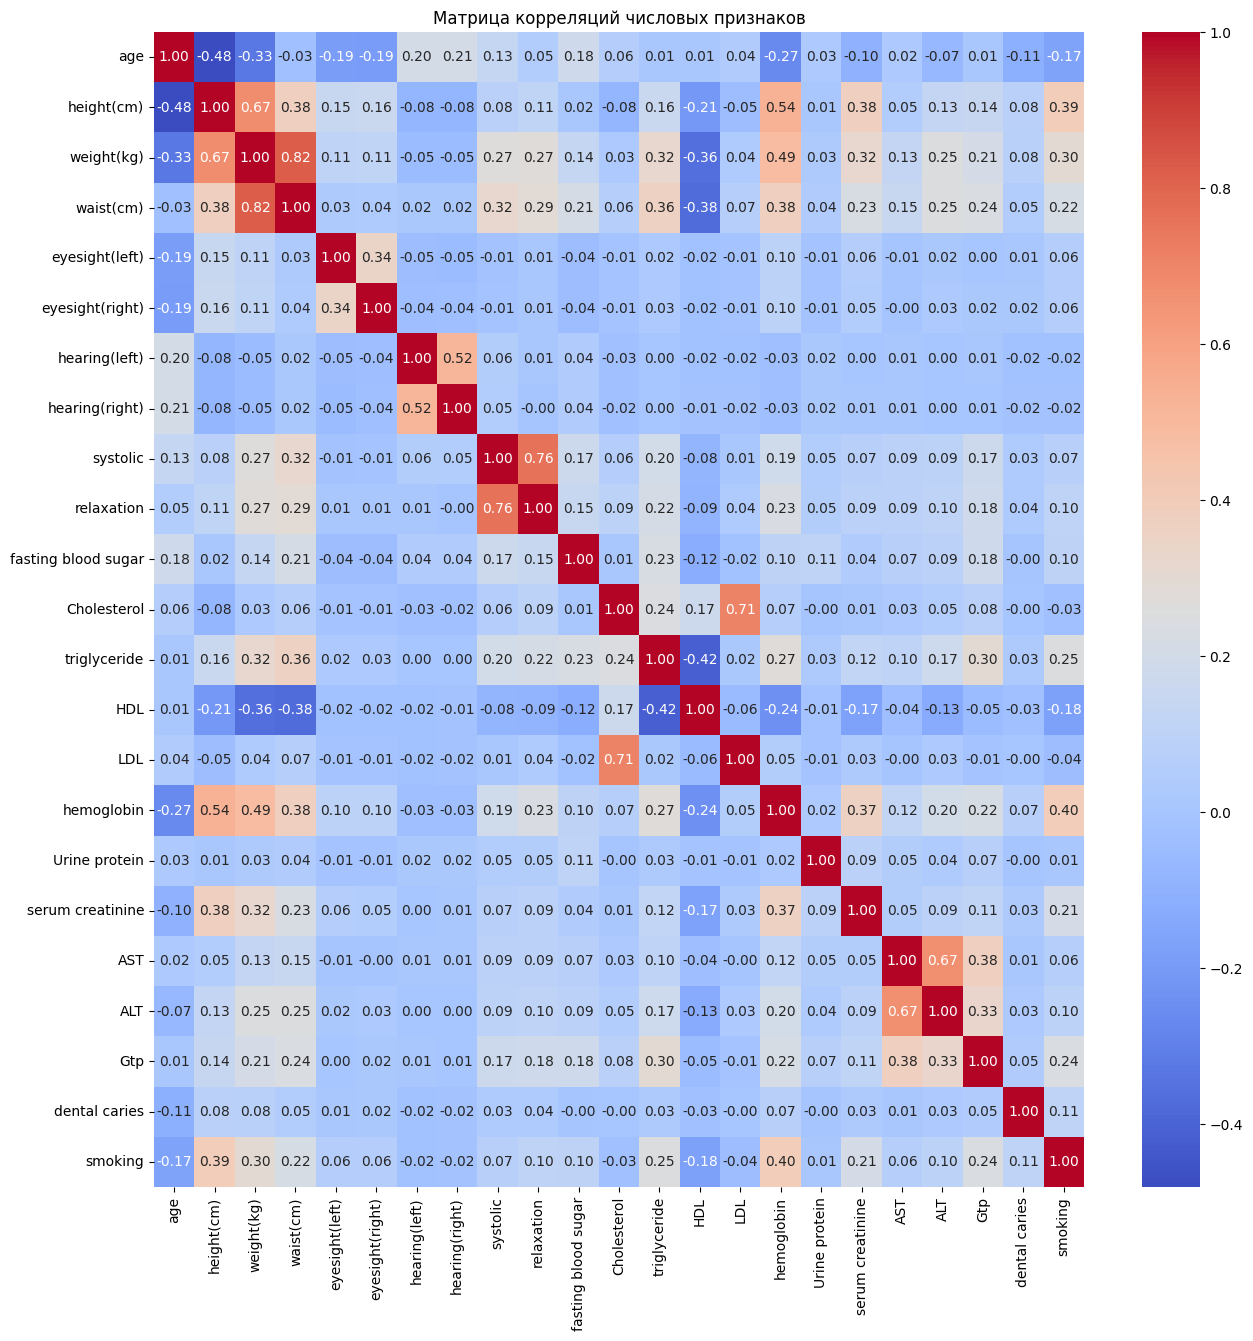

In [13]:
# Матрица корреляций
plt.figure(figsize=(15, 15))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Матрица корреляций числовых признаков")
plt.show()

В данных присутствуют ожидаемые корреляции между height-weight, weight-weist, ALT-AST, Cholesterol-LDL, relaxation-systolic, hearing(left)-hearing(right). Оставим данные без изменений.

### Разделение данных

In [14]:
X = df.drop(columns=[TARGET])
y = df[TARGET]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE
)

# Нормализация числовых данных
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print(f"X_train.shape={X_train.shape}, y_train.shape={y_train.shape}")
print(f"X_test.shape={X_test.shape}, y_test_poly.shape={y_test.shape}")

X_train.shape=(26773, 22), y_train.shape=(26773,)
X_test.shape=(6694, 22), y_test_poly.shape=(6694,)


## Обучение моделей

In [15]:
SEARCH_PARAMS = False

if SEARCH_PARAMS:
    param_dist = {
        "max_depth": [None, 5, 10, 15, 20, 30, 40, 50],
        "min_samples_split": [2, 5, 10, 20],
        "min_samples_leaf": [1, 2, 5, 10],
        "criterion": ["gini", "entropy", "log_loss"],
    }

    dtc = DecisionTreeClassifier(random_state=RANDOM_STATE)
    random_search = RandomizedSearchCV(
        dtc, param_dist, n_iter=200, cv=5, n_jobs=-1, scoring="f1"
    )
    random_search.fit(X_train, y_train)

    print("Лучшие параметры:", random_search.best_params_)

Лучшие параметры: {'min_samples_split': 20, 'min_samples_leaf': 5, 'max_depth': 5, 'criterion': 'log_loss'}

Выбранные параметры позволяют дереву решений сохранять баланс между точностью и обобщающей способностью. Максимальная глубина (max_depth = 5), минимальный размер узлов (min_samples_split = 20 и min_samples_leaf = 5) предотвращает излишнюю детализацию, а критерий log_loss делает модель более устойчивой к шуму в данных.

In [16]:
# Лучшая модель
best_params = {
    "min_samples_split": 20,
    "min_samples_leaf": 5,
    "max_depth": 5,
    "criterion": "log_loss",
}
best_dtc = DecisionTreeClassifier(**best_params, random_state=RANDOM_STATE)
best_dtc.fit(X_train, y_train)

# Предсказания на тестовых данных
y_pred = best_dtc.predict(X_test)
y_prob = best_dtc.predict_proba(X_test)[:, 1]

### Оценка качества моделей

In [17]:
def get_metrics(y_test, y_pred, y_prob):
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_prob)

    return accuracy, precision, recall, f1, roc_auc


# Сравнительная таблица качества моделей
quality_comparison = pd.DataFrame(
    {
        "Metrics": ["accuracy", "precision", "recall", "f1", "roc_auc"],
        "DecisionTreeClassifier": [
            *map(lambda x: round(x, 2), get_metrics(y_test, y_pred, y_prob))
        ],
    }
)

quality_comparison

,Metrics,DecisionTreeClassifier
0,accuracy,0.72
1,precision,0.62
2,recall,0.62
3,f1,0.62
4,roc_auc,0.79


Полученные метрики показывают, модель демонстрирует приемлемую точность и способность к обобщению (несмотря на дисбаланс классов), что делает её пригодной для решения данной задачи.

## Визуальное представление дерева решений

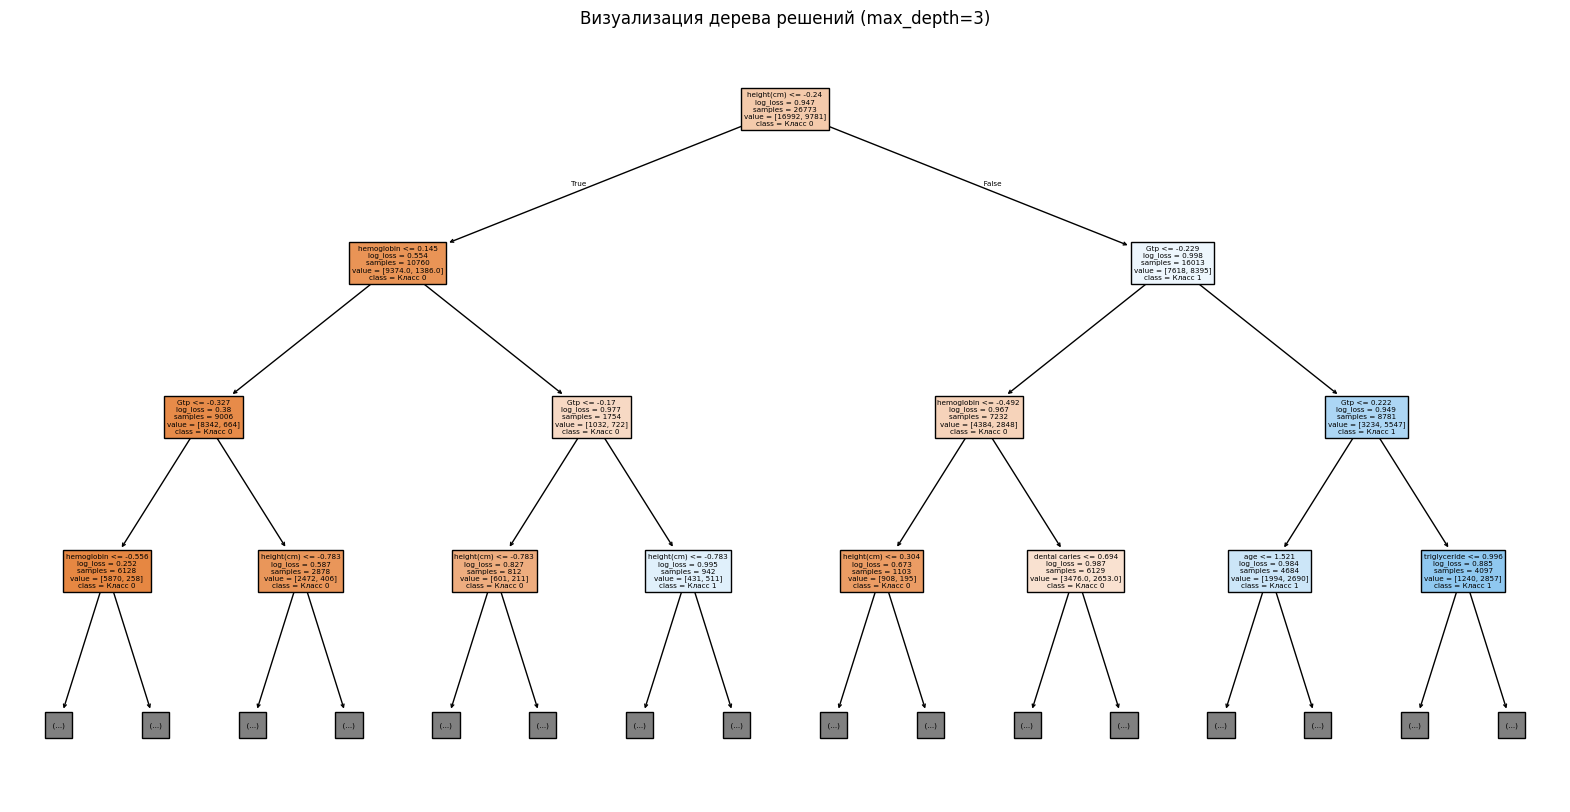

In [18]:
plt.figure(figsize=(20, 10))
plot_tree(
    best_dtc,
    filled=True,
    feature_names=X.columns,
    class_names=["Класс 0", "Класс 1"],
    max_depth=3,
)
plt.title("Визуализация дерева решений (max_depth=3)")
plt.show()

Узлами с наименьшими значениями log_loss являются GTP <= -0.327, hemoglobin <= -0.556, height(cm) <= -0.783. Чем меньше значения данных признаков, тем уверенне модель в отрицательной метке класса.

## Выбор наиболее важного признака

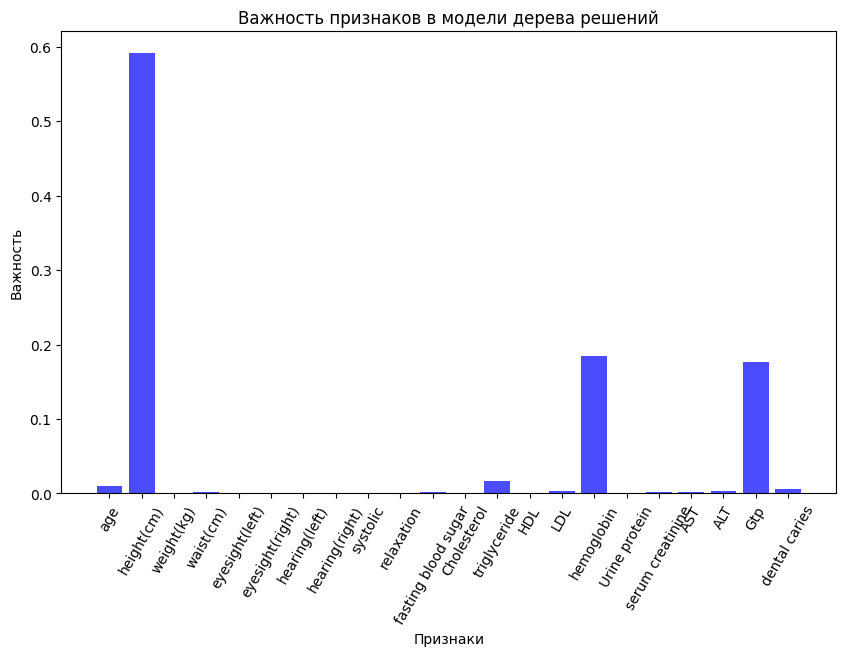

Наиболее важный признак: height(cm)


In [19]:
# Получение значимости признаков и визуализация
feature_importances = best_dtc.feature_importances_

plt.figure(figsize=(10, 6))
plt.bar(X.columns, feature_importances, color="blue", alpha=0.7)
plt.xticks(rotation=60)
plt.xlabel("Признаки")
plt.ylabel("Важность")
plt.title("Важность признаков в модели дерева решений")
plt.show()

# Вывод самого важного признака
most_important_idx = np.argmax(feature_importances)
print(f"Наиболее важный признак: {X.columns[most_important_idx]}")

Можно видеть, что наиболее важным признаком является height(cm).

## Модель с одним признаком

In [20]:
best_dtc_one_f = DecisionTreeClassifier(**best_params, random_state=RANDOM_STATE)
best_dtc_one_f.fit(np.expand_dims(X_train[:, most_important_idx], axis=-1), y_train)

# Предсказания на тестовых данных
y_pred_one_f = best_dtc_one_f.predict(
    np.expand_dims(X_test[:, most_important_idx], axis=-1)
)
y_prob_one_f = best_dtc_one_f.predict_proba(
    np.expand_dims(X_test[:, most_important_idx], axis=-1)
)[:, 1]

Оценка качества модели с одним признаком.

In [21]:
quality_comparison["DecisionTreeClassifier (one feature)"] = [
    *map(lambda x: round(x, 2), get_metrics(y_test, y_pred_one_f, y_prob_one_f))
]

quality_comparison

,Metrics,DecisionTreeClassifier,DecisionTreeClassifier (one feature)
0,accuracy,0.72,0.68
1,precision,0.62,0.56
2,recall,0.62,0.63
3,f1,0.62,0.59
4,roc_auc,0.79,0.74


Можно видеть, что качество модели снизилось.

## Дерево решений для модели с одним признаком

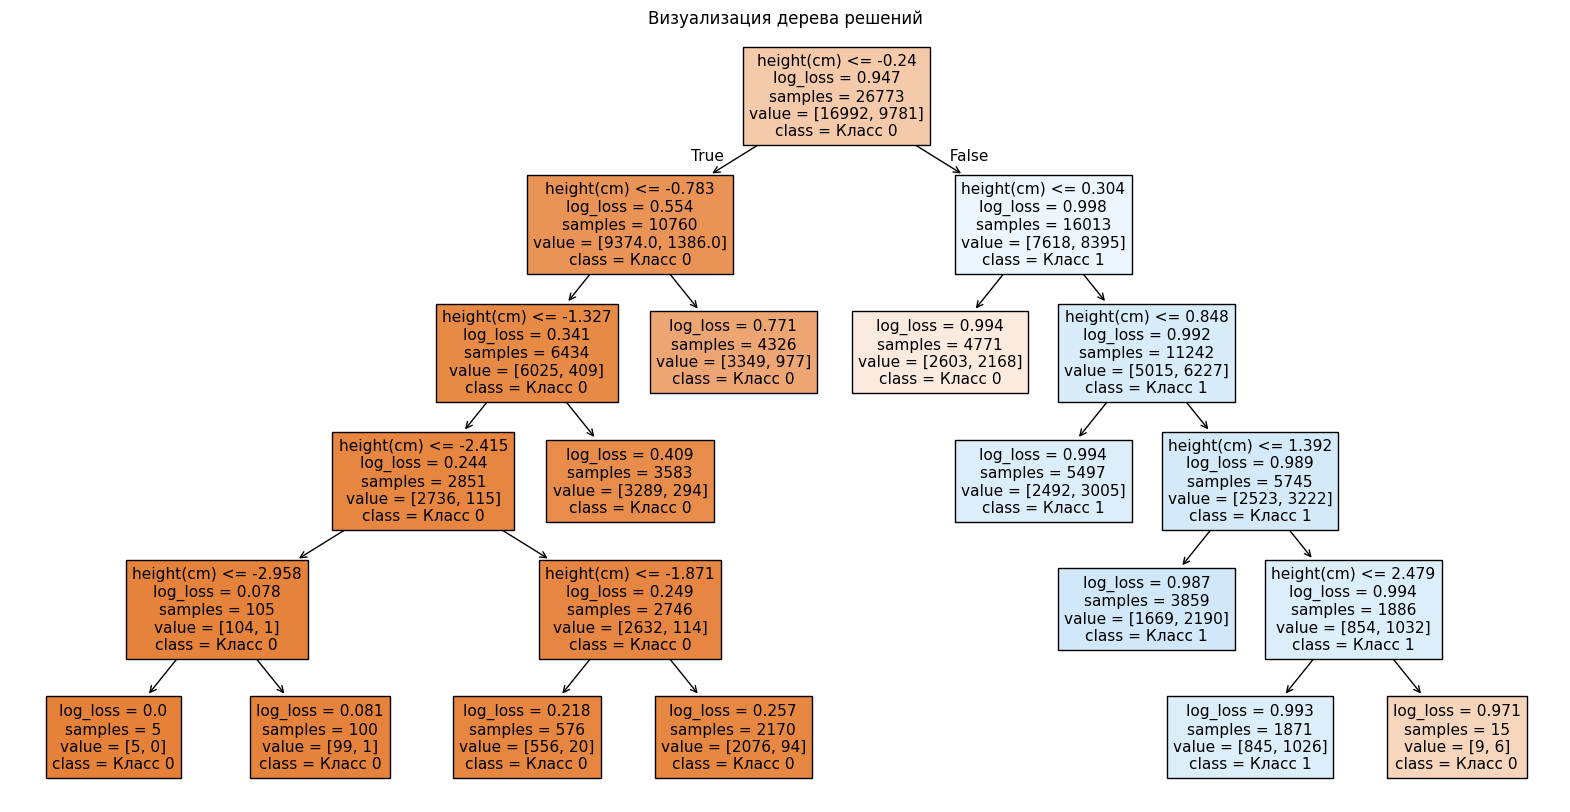

In [22]:
plt.figure(figsize=(20, 10))
plot_tree(
    best_dtc_one_f,
    filled=True,
    feature_names=[X.columns[most_important_idx]],
    class_names=["Класс 0", "Класс 1"],
)
plt.title("Визуализация дерева решений")
plt.show()

Узлами с наименьшими значениями log_loss являются height(cm) <= -1.327, height(cm) <= -2.415, height(cm) <= -2.958, height(cm) <= -1.871, т.е. чем ниже рост человека тем модель увереннее в метке класса 0.